In [1]:
import torch
import torchvision
import torchvision.transforms as transform
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim

In [2]:
# transform = transform.Compose(
#     [
#         transform.Scale(224),
#         transform.ToTensor(),
#         transform.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ]
# )

transform = transform.Compose([
    transform.RandomSizedCrop(227),
    transform.RandomHorizontalFlip(),
    transform.ToTensor(),
    transform.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                          std = [ 0.229, 0.224, 0.225 ]),
])

In [3]:
trainset = torchvision.datasets.ImageFolder(
    root='./data/unesco/images/', transform = transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers=2)

testset = torchvision.datasets.ImageFolder(
    root='./data/unesco_val/images/', transform = transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)


classes = trainset.classes

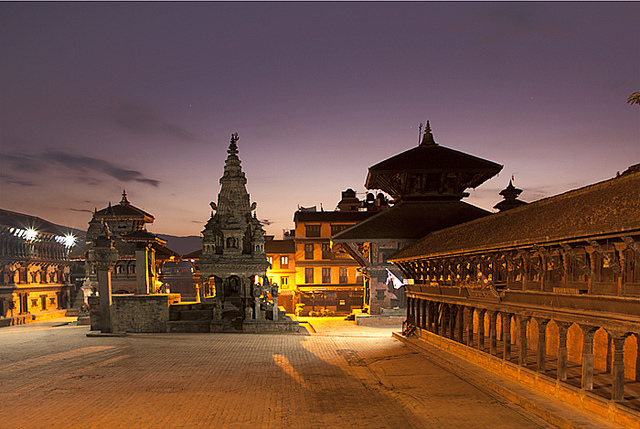

In [4]:
import torch as t
from torchvision.transforms import ToPILImage
from IPython.display import Image
to_img = ToPILImage()

a = t.Tensor(3, 227, 227).normal_()
to_img(a)

Image('./data/unesco/images/bhaktapur/bhaktapur_10.jpg')

In [5]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

net = AlexNet()

In [6]:
#net = models.resnet18()
criterion = nn.CrossEntropyLoss()
# criterion = nn.Softmax()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(10):
    print ('Training at epoch = ', epoch)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get the inputs
        inputs, labels = data
        
        #wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.data[0]
        if i % 200 == 199:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 200))
            running_loss = 0.0
            
            
print('Finished Training')

Training at epoch =  0


In [ ]:
# from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torchvision.transforms import ToPILImage
import torchvision.transforms as transform
from PIL import Image

# input_data = mpimg.imread('./data/UNESCO10_Test/boudhanath/boudhanath_100.jpg')
# input_data = Image.open('./data/UNESCO10_Test/boudhanath/boudhanath_100.jpg')

%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# print(input_data)

# show(input_data)
# images = transform.ToPILImage()(images)
#input_data = transform.ToTensor()(input_data)

# show(images)

GroundTruth:  pashupati pashupati pashupati pashupati


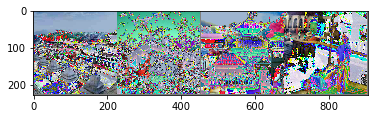

In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
outputs = net(Variable(images))

RuntimeError: size '[-1 x 400]' is invalid for input of with 179776 elements at /py/conda-bld/pytorch_1490980628440/work/torch/lib/TH/THStorage.c:55

In [11]:
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j][0]]
                              for j in range(4)))

NameError: name 'outputs' is not defined

In [12]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print(' Accuracy of the network on the 1000 test images: %d %%' % 
      (100 * correct / total))

RuntimeError: size '[-1 x 400]' is invalid for input of with 179776 elements at /py/conda-bld/pytorch_1490980628440/work/torch/lib/TH/THStorage.c:55

In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(2):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

RuntimeError: size '[-1 x 400]' is invalid for input of with 179776 elements at /py/conda-bld/pytorch_1490980628440/work/torch/lib/TH/THStorage.c:55

In [14]:
validateSet = torchvision.datasets.ImageFolder(
    root='./data/Test', transform = transform
)

validateLoader = torch.utils.data.DataLoader(validateSet, batch_size=4)

In [15]:
# correct = 0
# total = 0
# for data in validateLoader:
#     images, labels = data
#     outputs = net(Variable(images))
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum()
    
# print(' Accuracy of the network on Test image: %d %%' % 
#       (100 * correct / total))